In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ensemble.model import EnsembleDistribution, EnsembleFitter

name_csv = pd.read_csv("data/NAME_microdata.csv", encoding="ISO-8859-1")
name_csv = name_csv[["nid", "sex", "sex_id", "fpg_mmol", "year_id", "location_id", "age_cat", "is_outlier", "sample_weight"]]
data = name_csv.to_parquet("data/NAME_microdata.parquet")
name = pd.read_parquet("data/NAME_microdata.parquet")
name = name[name["is_outlier"] != 1]
tmap = pd.read_csv("data/NAME_task_map.csv")
stgpr_means = pd.read_csv("data/NAME_stgpr_result.csv")
est_vars = pd.read_csv("data/NAME_custom_sd_result.csv")
# print(name_csv["sample_weight"].unique())
# print(name_csv[["age", "age_cat"]].drop_duplicates())
# print(np.unique(name_csv["age"]))

/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_62769/536400165.py:6: DtypeWarning: Columns (6,7,12,16,17,35,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  name_csv = pd.read_csv("data/NAME_microdata.csv", encoding="ISO-8859-1")


In [2]:
# select columns containing means
mean_vals = stgpr_means.iloc[:, 9:259].mean(axis=1)
# create 10 year age bins from 5 year age bins
stgpr_means["age_cat"] = (stgpr_means["age_group_years_start"] // 10) * 10
stgpr_means = stgpr_means[["age_cat", "location_id", "sex_id", "year_id"]].copy()
stgpr_means["means"] = mean_vals
stgpr_means = stgpr_means.groupby(["sex_id", "year_id", "age_cat"])["means"].mean().reset_index()
merged_means_est = tmap.merge(stgpr_means, on=['age_cat', 'sex_id', 'year_id'], how='left')

name["w_fpg"] = name["fpg_mmol"] * name["sample_weight"]
micro_weights = name.groupby(["sex_id", "year_id", "age_cat"])["sample_weight"].transform("sum")
name["w_fpg"] = name["w_fpg"] / micro_weights
micro_means = name.groupby(["sex_id", "year_id", "age_cat"])["w_fpg"].sum().reset_index()
# print(micro_means.head())
micro_means = micro_means.rename(columns={"w_fpg": "fpg_mmol"})
merged_means_micro = tmap.merge(micro_means, on=["age_cat", "sex_id", "year_id"], how="left")

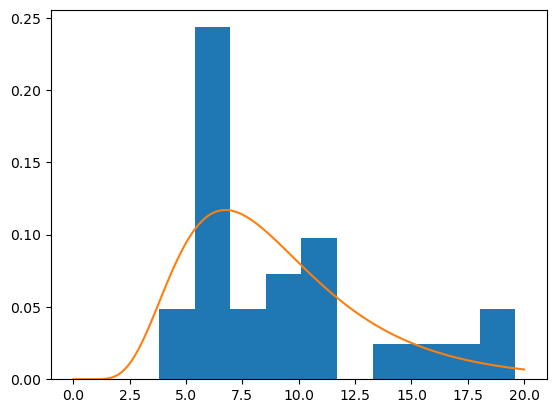

In [8]:
# merged_means_micro.sort_values("fpg_mmol", ascending=False)
ex1 = "location_id==147 and year_id==1990 and age_cat==60"
ex2 = "location_id==147 and year_id==1990 and age_cat==60"
subset = name.query("location_id==145 and year_id==2006 and sex_id==1 and age_cat==60")
plt.hist(subset["fpg_mmol"], density=True)# , weights=subset["sample_weight"])
DISTRIBUTIONS = ["gamma", "invgamma", "lognormal", "fisk"]
model = EnsembleFitter(DISTRIBUTIONS, "KS")
# print(subset["fpg_mmol"].values)
res = model.fit(subset["fpg_mmol"].values)
support = np.linspace(0, 20, 1000)
plt.plot(support, res.ensemble_distribution.pdf(support))
# print(merged_means_est.shape)
# print(tmap.columns)
# print(merged_means_micro.columns)

In [4]:
# merged_means_est.query("location_id==145 and year_id==2006 and sex_id==1 and age_cat==60")

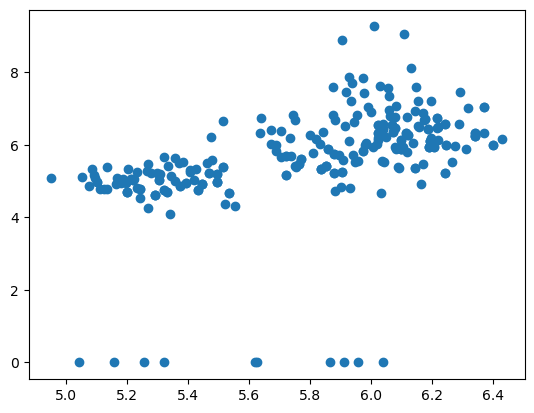

In [5]:
plt.scatter(merged_means_est["means"], merged_means_micro["fpg_mmol"])